# Decision Trees and Random Forests: Application on feature data for IMR90 cell line in GREG.

### Author : Shaurya Jauhari (Email: shauryajauhari@gzhmu.edu.cn)
### Last Reviewed : December 15th 2020

## Background

This notebook assesses variaegated implementations of the random forest models for the data dervied from the IMR90 cell-line in GREG. The data for the same and other cell-types for GREG is available at this <a href = "https://zenodo.org/deposit/4265559"> link</a>.

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(ggplot2))

### <a id=link3>1.2 Dataset Handling </a>

In [2]:
imr90gregStandard <- read.table("../../transcriptionFactoriesGREG/MachineLearning/data/IMR90forML.txt", header = TRUE) ## loading data
imr90greg <- imr90gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(imr90greg)

,CTCF,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
2,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
3,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
4,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
5,0.0000000,0.02845434,0.03670386,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
6,0.1229087,0.02845434,0.18351931,0.02756696,0.03354488,0,0,0.206122,0.05739237,Non-Hub


In [4]:
rownames(imr90greg) <- c()
imr90greg$Class <- as.numeric(as.factor(imr90greg$Class))
imr90greg$Class <- ifelse(imr90greg$Class == 2, 0, 1)
head(imr90greg$Class)

[1] 0 0 0 0 0 0

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(imr90greg), replace = TRUE, prob = c(0.8,0.2))
train <- imr90greg[dataPartition==1,]
test <- imr90greg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1368401 training examples and 342602 for testing.

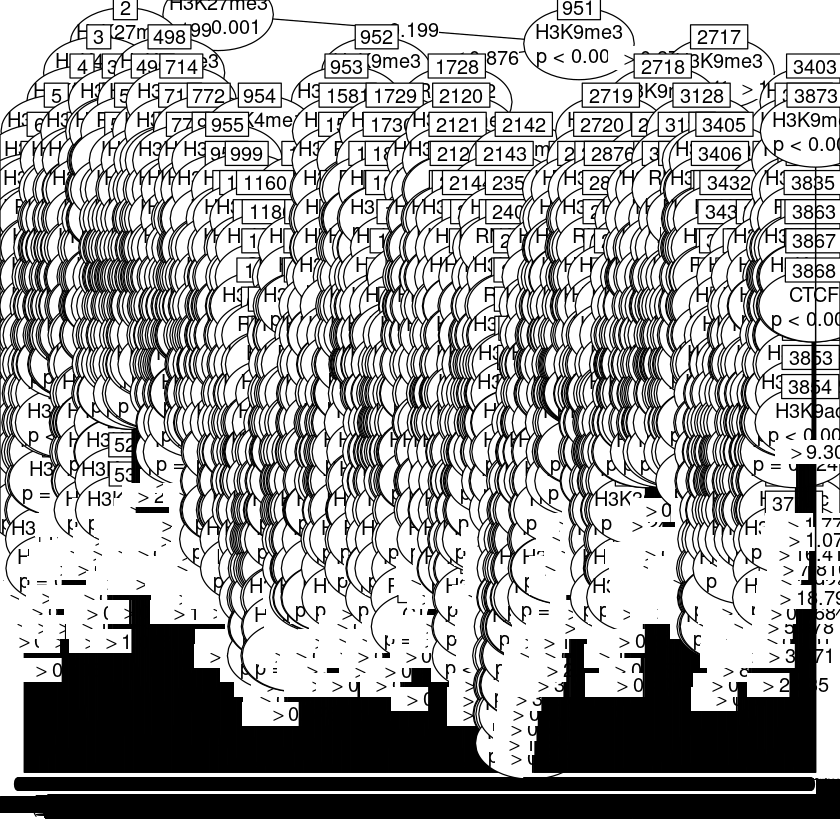

In [7]:
imr90Tree <- ctree(Class ~ ., data= train)
plot(imr90Tree)

In [8]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(imr90Tree, "rf", test, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 292883  49719
The accuracy of the model is 85.48783 % 
The misclassification error of the model is 14.51217 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [9]:
treePred <- predict(imr90Tree,test)
head(ifelse(treePred > 0.5, "Hub", "Non-Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub


In [10]:
treePredProb <- predict(imr90Tree,test, type="prob")
head(treePredProb)

[[1]]
[1] 0.0373639

[[2]]
[1] 0.0373639

[[3]]
[1] 0.0373639

[[4]]
[1] 0.0373639

[[5]]
[1] 0.07852349

[[6]]
[1] 0.09450437

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 6:4 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [11]:
set.seed(03)
dataPartition64 <- sample(2, nrow(imr90greg), replace = TRUE, prob = c(0.6,0.4))
train64 <- imr90greg[dataPartition64==1,]
test64 <- imr90greg[dataPartition64==2,]

In [12]:
cat("We have",nrow(train64),"training examples and",nrow(test64),"for testing.")

We have 1026739 training examples and 684264 for testing.

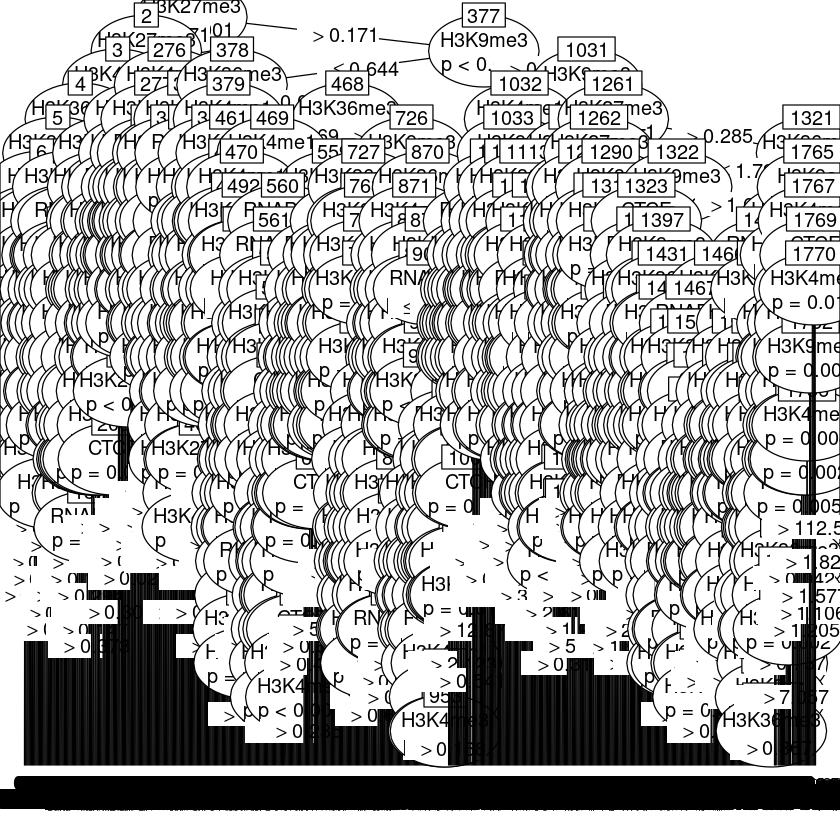

In [13]:
imr90Tree64 <- ctree(Class ~ ., data= train64)
plot(imr90Tree64)

In [14]:
treePred64 <- predict(imr90Tree64, test64, type="response")
treePred64 <- ifelse(treePred64 > 0.5, "1", "0")

In [15]:
modelPerformance(imr90Tree64, "rf", test64, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 585177  99087
The accuracy of the model is 85.51919 % 
The misclassification error of the model is 14.48081 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [16]:
table(train$Class)


      0       1 
1170501  197900 

This clearly shows the over-representation of the positive class ("0") in the data upon which the model is supposed to be built. We need to make an effort to balance the class load.

In [17]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 1, k = 5, perc.under = 10100)
table(smoteData$Class)


     0      1 
199879 199879 

Now that the data is seemingly balanced, let's examine the performance of the model.

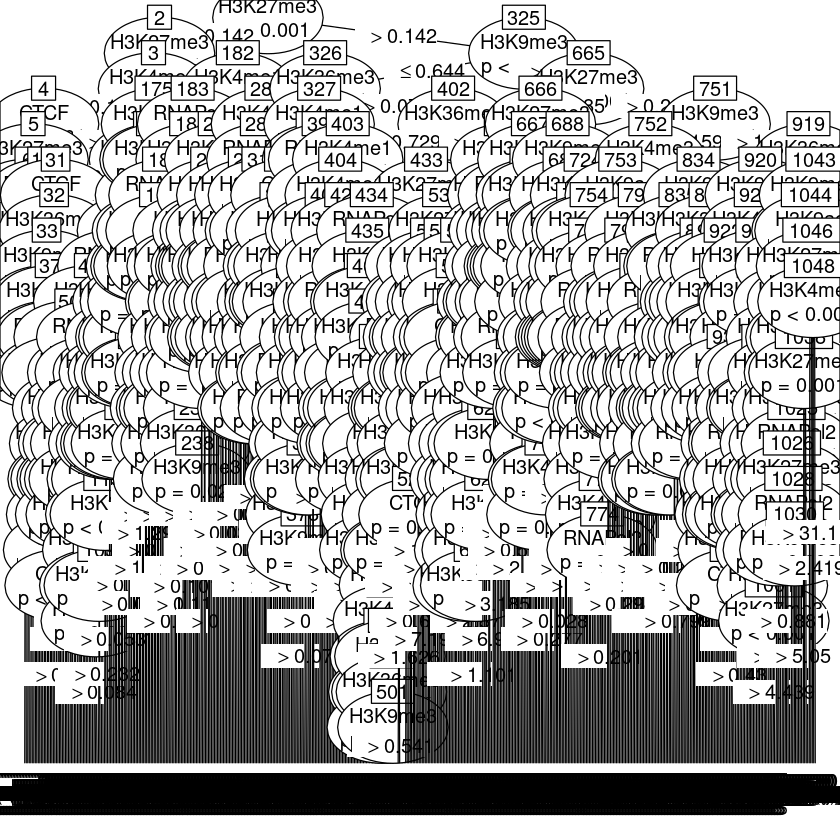

In [18]:
imr90SmoteTree <- ctree(Class ~ ., data= smoteData)
plot(imr90SmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [19]:
treeSmotePred <- predict(imr90SmoteTree, test)
head(treeSmotePred)

[1] 0 0 0 0 0 0
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0 163744  14867
        1 129139  34852
The accuracy of the model is 57.96697 % 
The misclassification error of the model is 42.03303 % 
The sensitivity of the model is 55.90765 % 
The specificity of the model is 70.09795 % 
The area under curve is 0.630028 



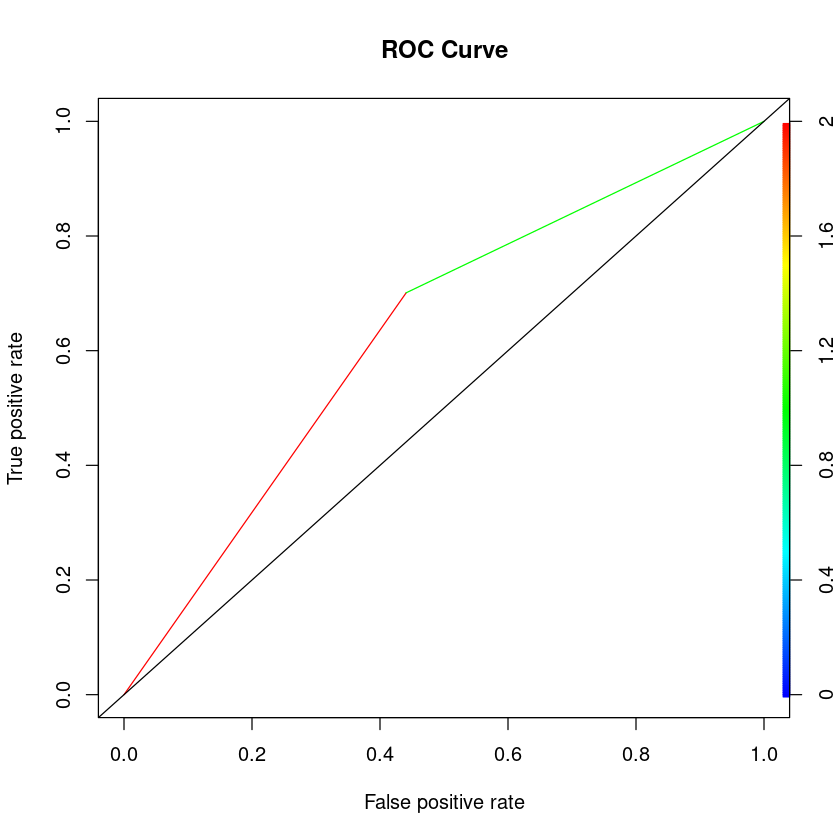

In [20]:
modelPerformance(imr90SmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Also, a notable observation is that the sensitivity and specificity are well balanced. Maybe, we should explore other options.

<p align="justify"> Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ). </p>

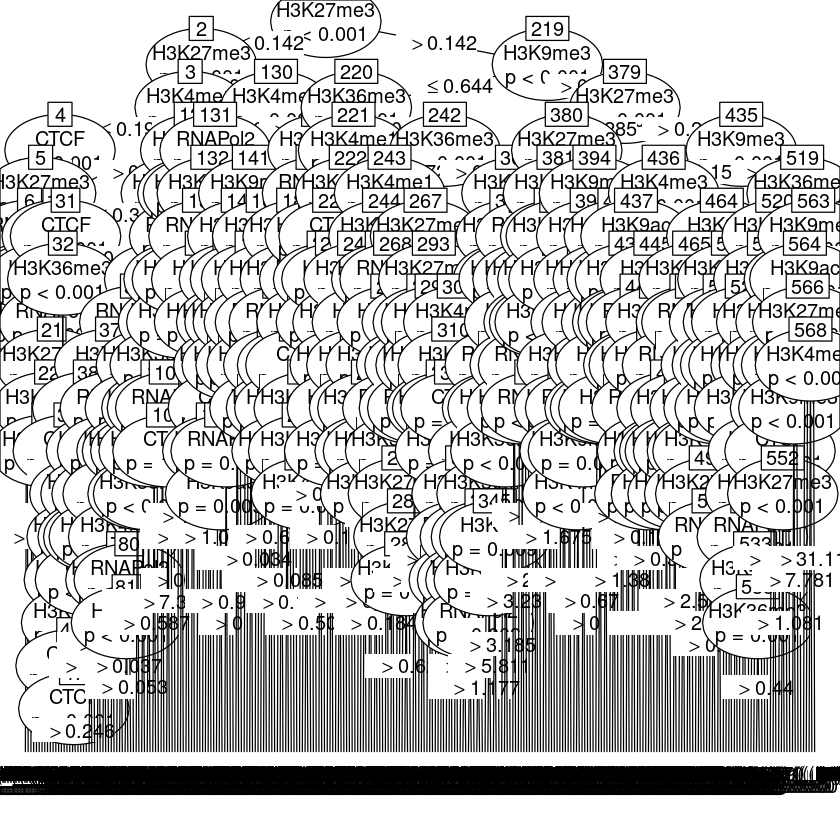

In [21]:
imr90SmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(imr90SmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 160450  14609
        1 132433  35110
The accuracy of the model is 57.08081 % 
The misclassification error of the model is 42.91919 % 
The sensitivity of the model is 54.78297 % 
The specificity of the model is 70.61687 % 
The area under curve is 0.6269992 



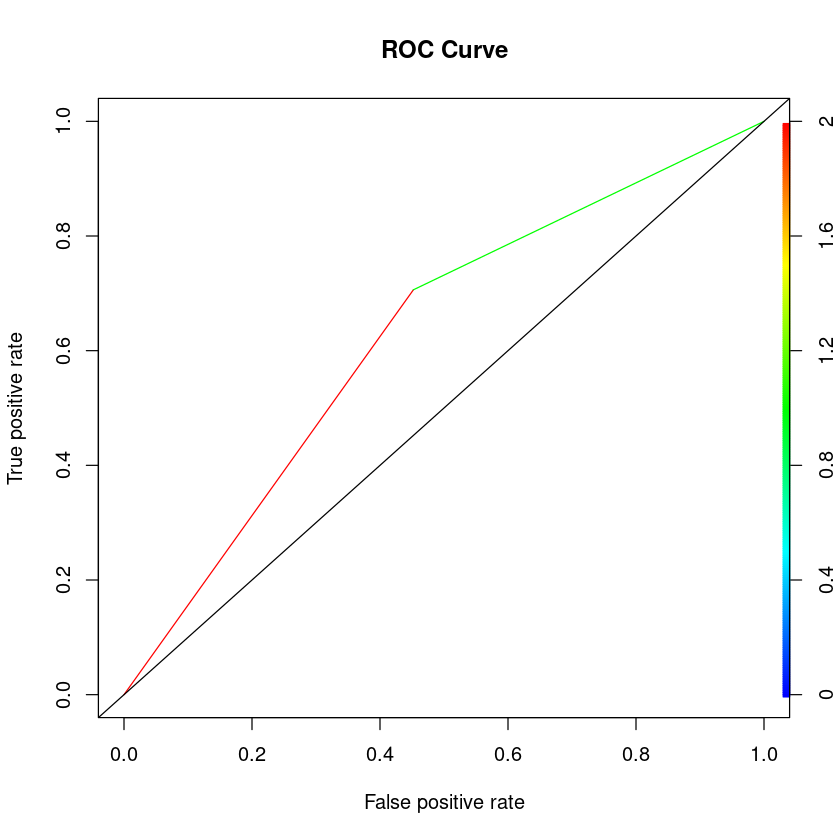

In [22]:
modelPerformance(imr90SmoteTreeAlt, "RF", test, Class)

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [23]:
imr90TreeAlt <- rpart(Class ~ ., data = smoteData)

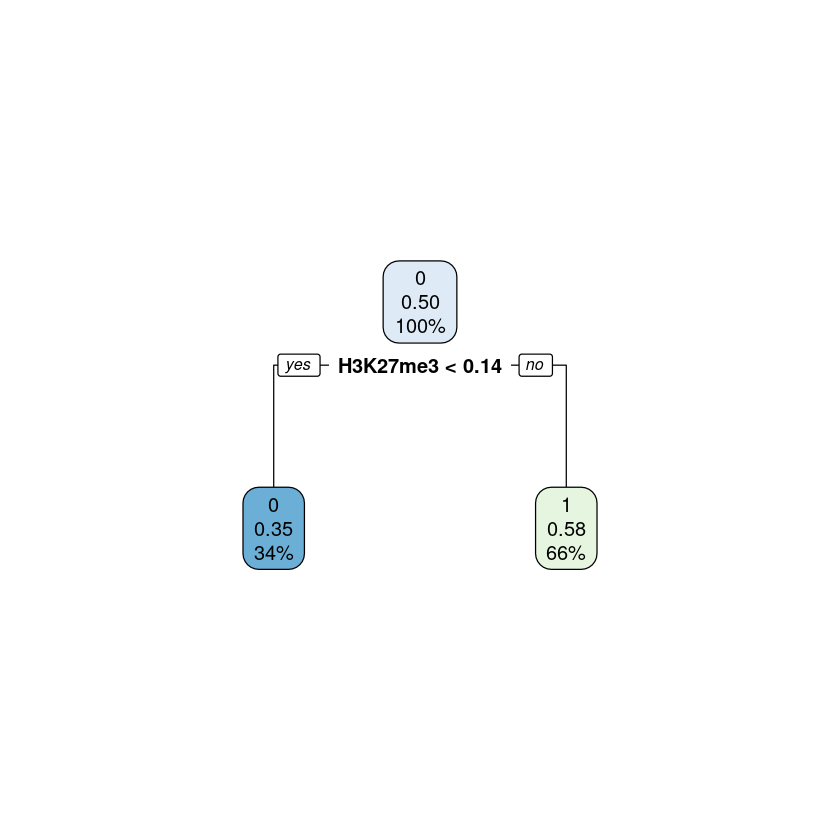

In [24]:
rpart.plot(imr90TreeAlt)

There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset) 

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [25]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
imr90gregSample <- imr90greg[sample(nrow(imr90greg), replace=T, size=0.1*nrow(imr90greg)),]

## Making thr response variable a 'factor', since we are attempting classification.

imr90gregSample$Class <- as.factor(imr90gregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(imr90gregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- imr90gregSample[dataPartition73 == 1,]
test73 <- imr90gregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [26]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    0     1 
59641 59937 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [27]:
# Execute random forest algorithm

imr90rf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(imr90rf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 5.29%
Confusion matrix:
      0     1 class.error
0 56636  3005  0.05038480
1  3318 56619  0.05535813


In [28]:
# Prediction and Confusion Matrix

imr90PredRF <- predict(imr90rf,test73)
confusionMatrix(imr90PredRF, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 40999  4255
         1  3091  3177
                                          
               Accuracy : 0.8574          
                 95% CI : (0.8544, 0.8604)
    No Information Rate : 0.8558          
    P-Value [Acc > NIR] : 0.1418          
                                          
                  Kappa : 0.3823          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.42748         
            Specificity : 0.92989         
         Pos Pred Value : 0.50686         
         Neg Pred Value : 0.90598         
             Prevalence : 0.14425         
         Detection Rate : 0.06166         
   Detection Prevalence : 0.12166         
      Balanced Accuracy : 0.67868         
                                          
       'Positive' Class : 1               
                  

Despite the high accuracy of the model at 85.74 %, a suitable prediction-ability for positive class (sensitivity) is quite low as compared to specificity (92 %). 

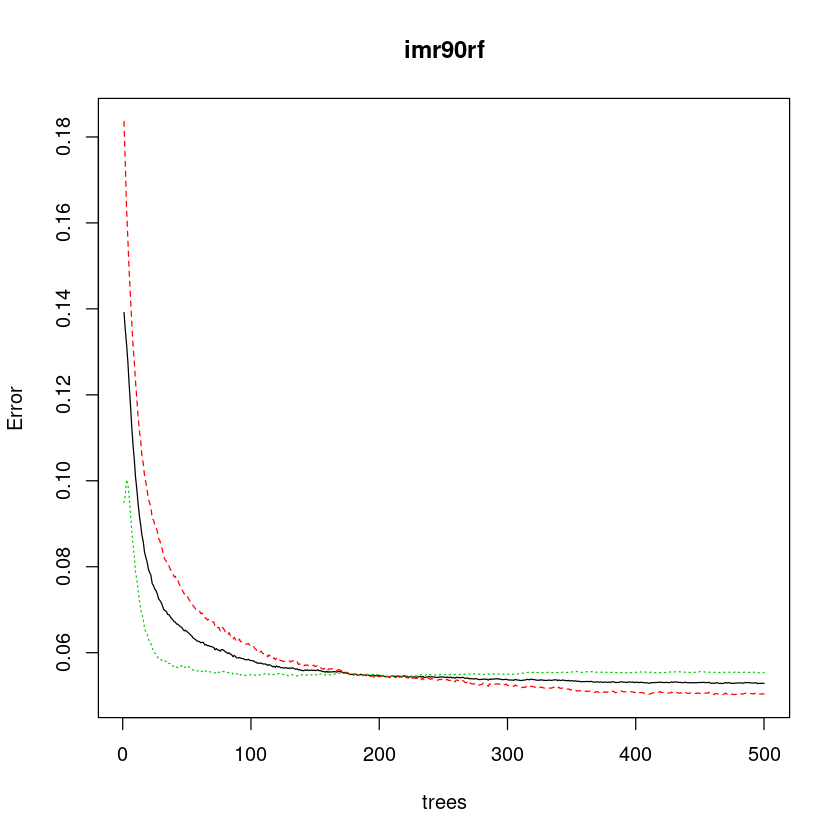

In [29]:
# Error rates (MSEs) of the Random Forest

plot(imr90rf)

The above plot shows that the error rate stablises after ~ 400 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 400. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [30]:
head(bothTrain)

,CTCF,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.2150902,0.02845434,0.03670386,0.00000000,0.06708976,0.04210443,0.00000000,0.3349483,0.2008733,0
2,0.3994533,0.00000000,0.29363089,0.00000000,0.00000000,0.04210443,0.47780285,0.0000000,0.5739237,0
3,0.2765446,0.19918038,0.07340772,0.02756696,0.03354488,0.04210443,0.05308921,0.3091830,0.2869618,0
4,0.3072717,0.17072604,0.07340772,0.00000000,0.03354488,0.00000000,0.10617841,2.1127507,0.8034932,0
5,0.4301804,3.55679257,0.40374247,0.30323660,0.36899369,0.21052213,0.15926762,0.8760186,0.9182779,0
6,0.4301804,0.14227170,0.00000000,0.02756696,0.00000000,0.00000000,0.05308921,0.2576525,0.2582657,0


mtry = 3  OOB error = 5.29% 
Searching left ...
mtry = 2 	OOB error = 5.94% 
-0.1231037 0.005 
Searching right ...
mtry = 6 	OOB error = 4.97% 
0.06052465 0.005 
mtry = 9 	OOB error = 5.22% 
-0.05029437 0.005 


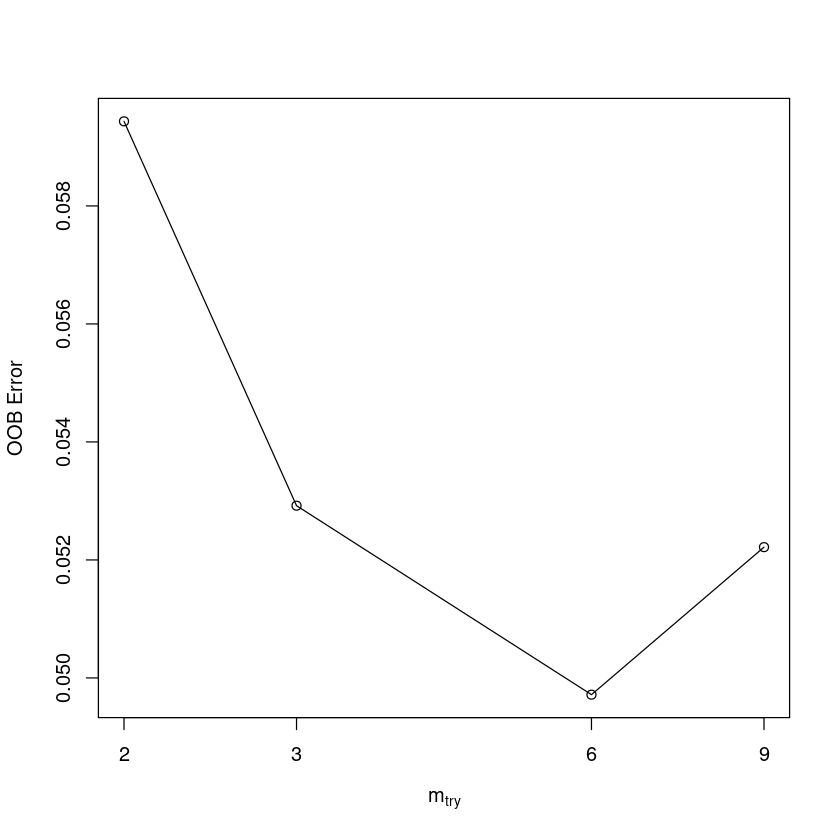

In [31]:
# Tuning mtry | stepfactor = 2

t2 <- tuneRF(bothTrain[,-10], bothTrain[,10],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)               

mtry = 3  OOB error = 5.3% 
Searching left ...
mtry = 1 	OOB error = 13.45% 
-1.538923 0.005 
Searching right ...
mtry = 9 	OOB error = 5.2% 
0.01815885 0.005 


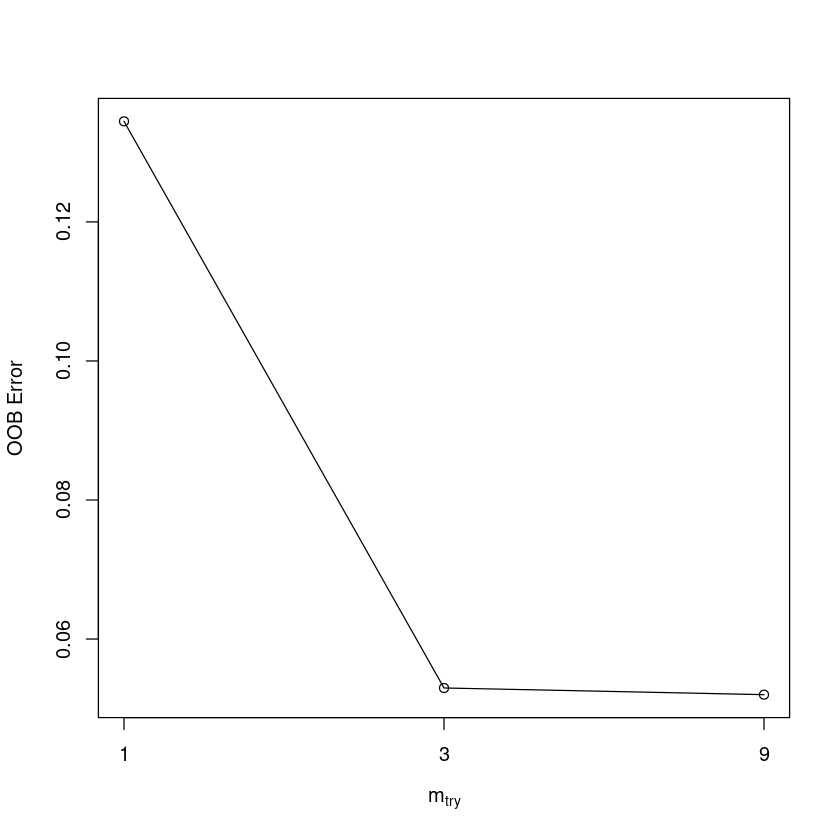

In [32]:
# Tuning mtry | stepfactor = 5

t3 <- tuneRF(bothTrain[,-10], bothTrain[,10],
            stepFactor = 5,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)   

mtry = 3  OOB error = 5.27% 
Searching left ...
mtry = 1 	OOB error = 13.2% 
-1.505397 0.005 
Searching right ...
mtry = 9 	OOB error = 5.18% 
0.01634921 0.005 


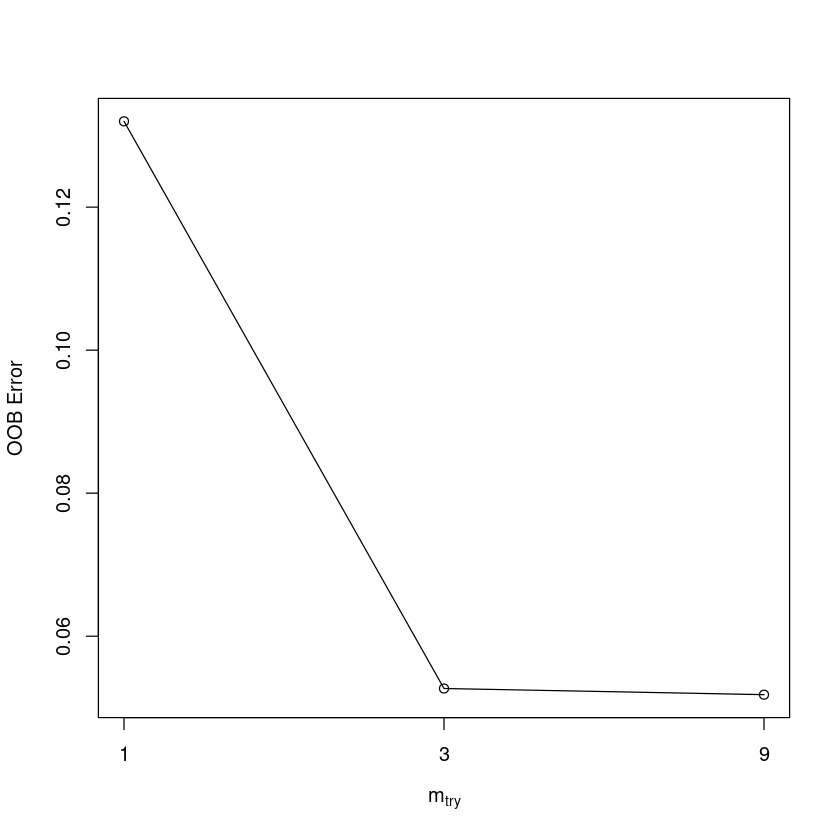

In [33]:
# Tuning mtry | stepfactor = 4

t4 <- tuneRF(bothTrain[,-10], bothTrain[,10],
            stepFactor = 4,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)   

mtry = 3  OOB error = 5.29% 
Searching left ...
mtry = 1 	OOB error = 13.12% 
-1.482595 0.005 
Searching right ...
mtry = 9 	OOB error = 5.2% 
0.01598101 0.005 


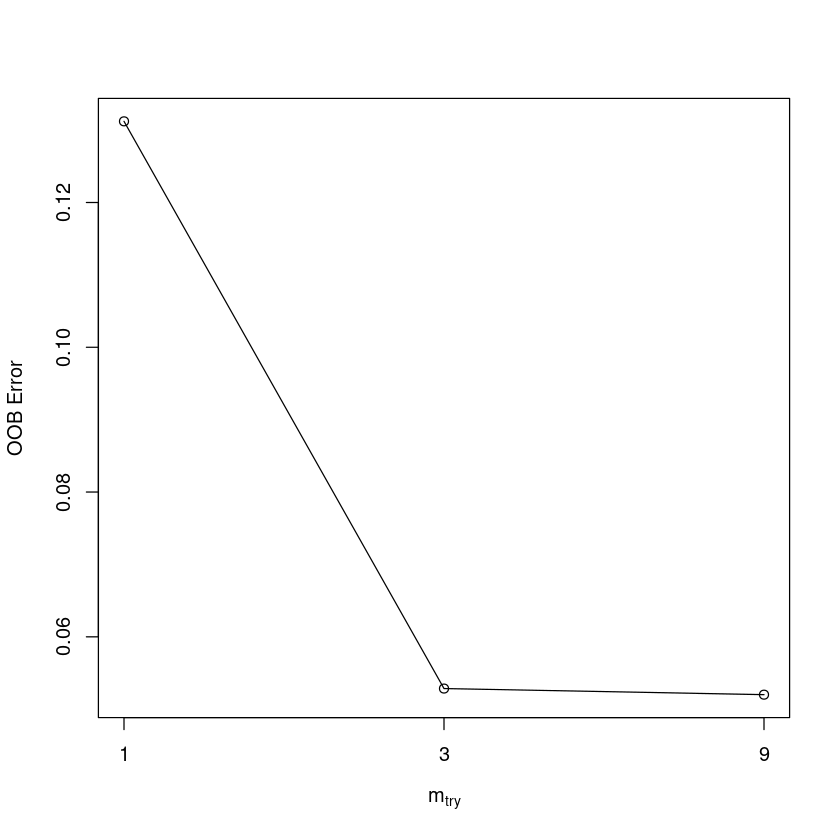

In [34]:
# Tuning mtry | stepfactor = 3

t5 <- tuneRF(bothTrain[,-10], bothTrain[,10],
            stepFactor = 3,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)   

I think we are good at *mtry* = 9; the error is minimum.

However, owing to the biasness in the model to predict negative class over positive class, let's make an attempt with *smoteData* flavor and examine any improvement; we did consider balanced samples in *bothTrain* though.

In [35]:
# Execute random forest algorithm

imr90rf1 <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 400)
print(imr90rf1)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 400) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 3

        OOB estimate of  error rate: 15.28%
Confusion matrix:
       0      1 class.error
0 180581  19298  0.09654841
1  41795 158084  0.20910151


For sure, this is way better than the previous one, with given improved estimate of sensitivity. We can observe the SMOTE transformation has a positive effect on the model's performance in making predictions for the minority class instances.

In [36]:
imr90PredRFOpt <- predict(imr90rf1,test73)
confusionMatrix(imr90PredRFOpt, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 39884   652
         1  4206  6780
                                          
               Accuracy : 0.9057          
                 95% CI : (0.9032, 0.9082)
    No Information Rate : 0.8558          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6814          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9123          
            Specificity : 0.9046          
         Pos Pred Value : 0.6171          
         Neg Pred Value : 0.9839          
             Prevalence : 0.1442          
         Detection Rate : 0.1316          
   Detection Prevalence : 0.2132          
      Balanced Accuracy : 0.9084          
                                          
       'Positive' Class : 1               
                  

The model performs well with the 70:30 data in terms of sensitivity and specificity; although for test data the model is marginally low on sensitivity. Regardless, we'll stick to the model.

The confusion matrix is
         Actual
Predicted      0      1
        0 261621  10435
        1  31262  39284
The accuracy of the model is 87.82932 % 
The misclassification error of the model is 12.17068 % 
The sensitivity of the model is 89.32611 % 
The specificity of the model is 79.01205 % 
The area under curve is 0.8416908 



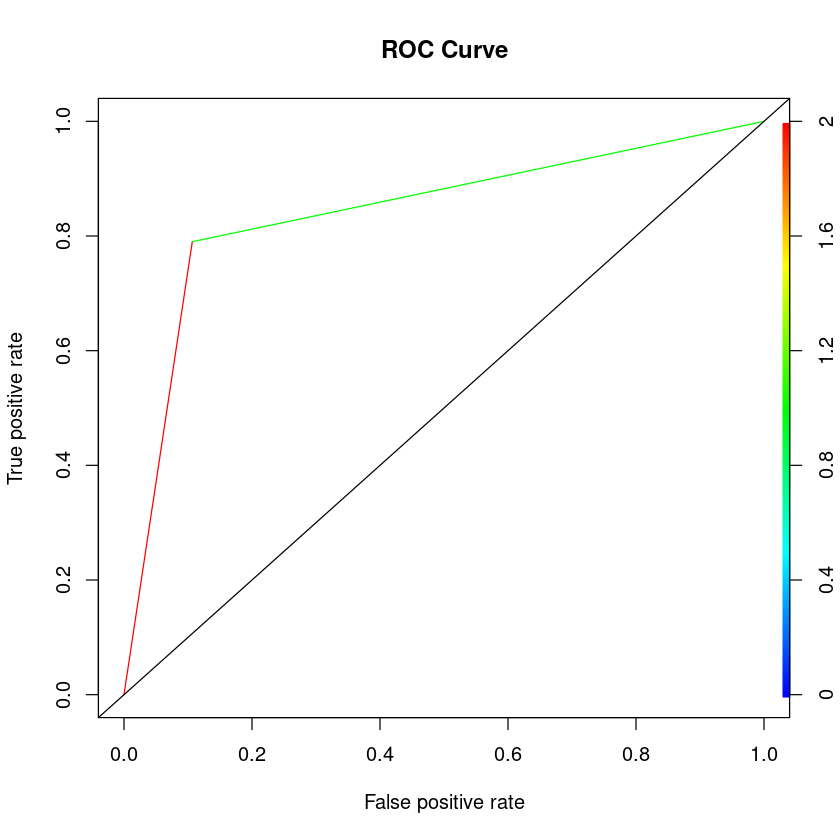

In [44]:
modelPerformance(imr90rf1, "RF", test, Class)

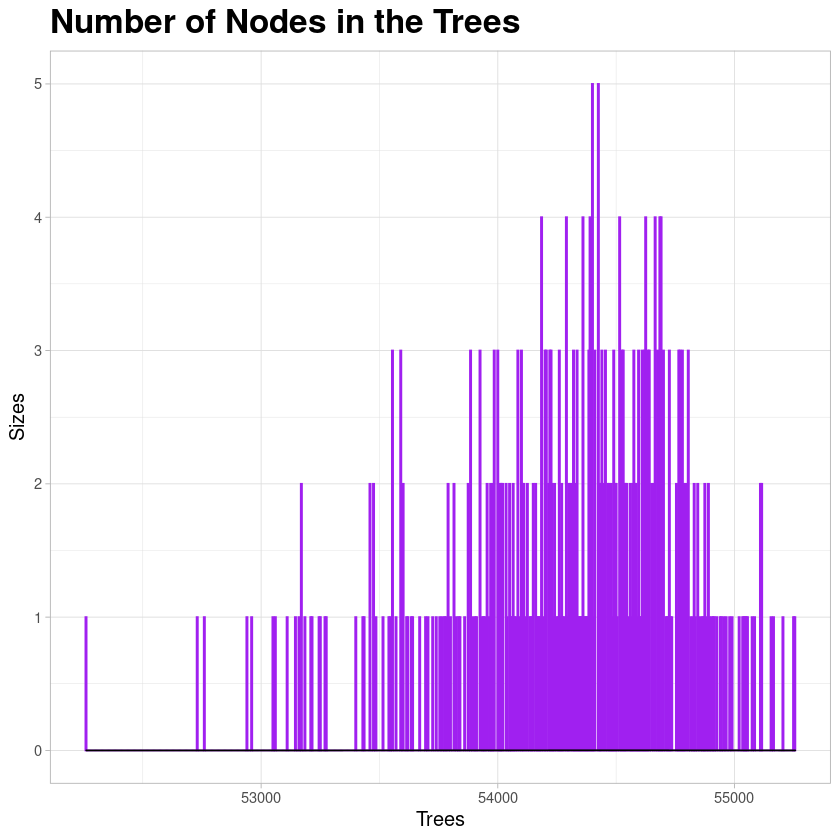

In [37]:
# Number of nodes for the trees

ts <- as.data.frame(treesize(imr90rf1), row.names = c())
ggplot(data = ts, aes(x = `treesize(imr90rf1)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

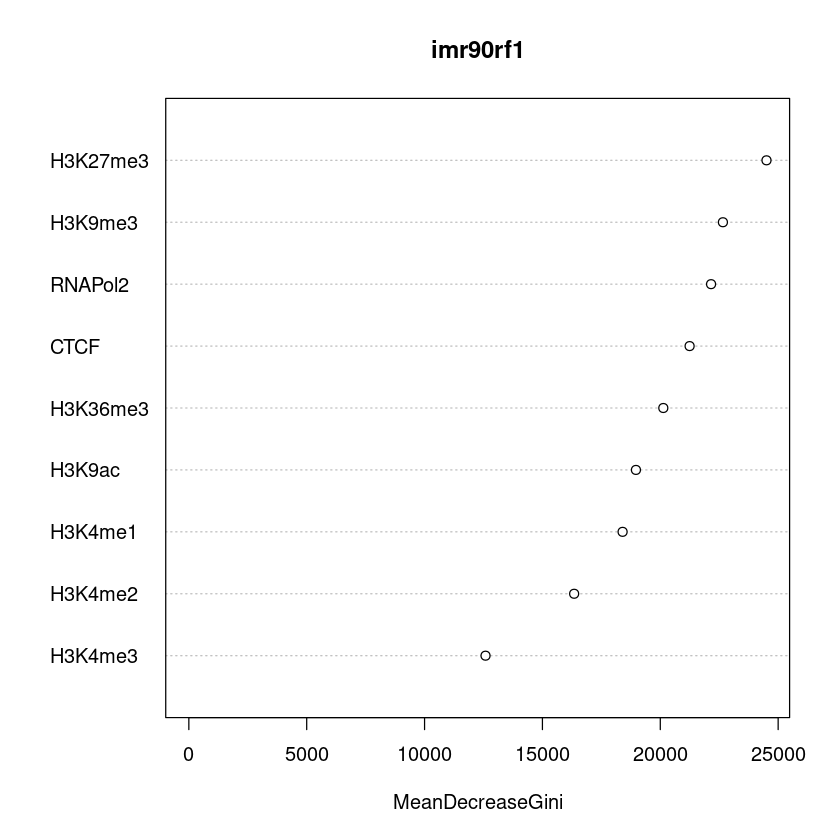

In [38]:
# Variable Importance

varImpPlot(imr90rf1)

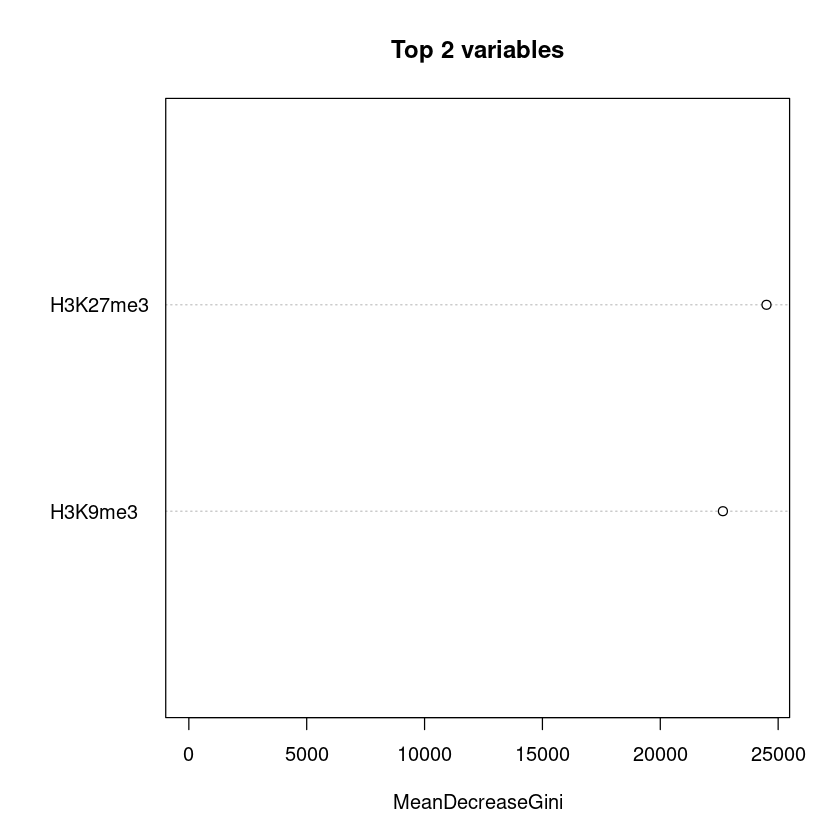

In [39]:
varImpPlot(imr90rf1 , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [40]:
importance(imr90rf1)

,MeanDecreaseGini
CTCF,21243.87
H3K27me3,24505.66
H3K36me3,20127.91
H3K4me1,18400.97
H3K4me2,16345.15
H3K4me3,12586.06
H3K9ac,18966.98
H3K9me3,22656.64
RNAPol2,22154.27


In [41]:
varUsed(imr90rf1)

[1] 2885443 2599106 2309516 2176602 2172333 1814826 2054876 2766338 2943007

This classification model of random forests projects **H3K27me3** as the most crucial variable with maximum instances used while contruction of trees.

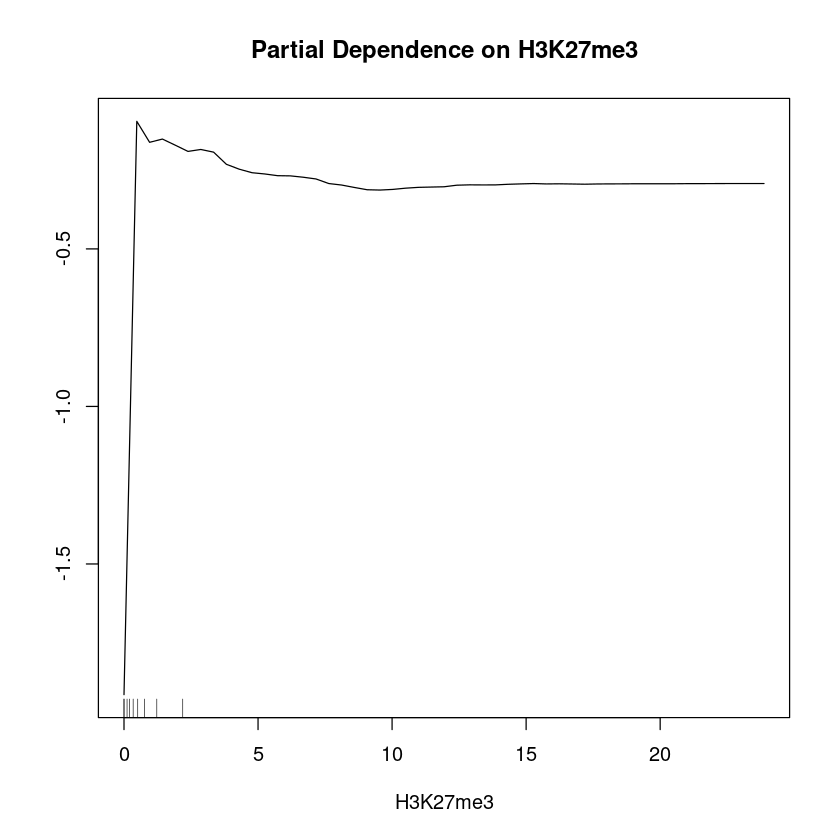

In [45]:
# Partial Dependence Plots

partialPlot(imr90rf1, smoteData, H3K27me3 , "1")

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [42]:
imr90gregModelPredictions <- predict(imr90rf1, imr90greg, type = "response")
imr90gregModelPredictionsProbs <- as.factor(imr90gregModelPredictions)

In [43]:
head(imr90gregModelPredictionsProbs)

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the IMR90 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [46]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the IMR90 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [47]:
imr90gregStandardRegionsClass <- imr90gregStandard[, c(1:3,13)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [48]:
head(imr90gregStandardRegionsClass)

,chr,start,end,Class
,<fct>,<int>,<int>,<fct>
1,chr1,1,2000,Non-Hub
2,chr1,2001,4000,Non-Hub
3,chr1,4001,6000,Non-Hub
4,chr1,6001,8000,Non-Hub
5,chr1,8001,10000,Non-Hub
6,chr1,10001,12000,Non-Hub


In [49]:
## Extracting chr21 data

imr90gregChr21NonHub <- imr90gregStandardRegionsClass[imr90gregStandardRegionsClass$chr=="chr21" & imr90gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
imr90gregChr21Hub <- imr90gregStandardRegionsClass[imr90gregStandardRegionsClass$chr=="chr21" & imr90gregStandardRegionsClass$Class=="Hub", ]

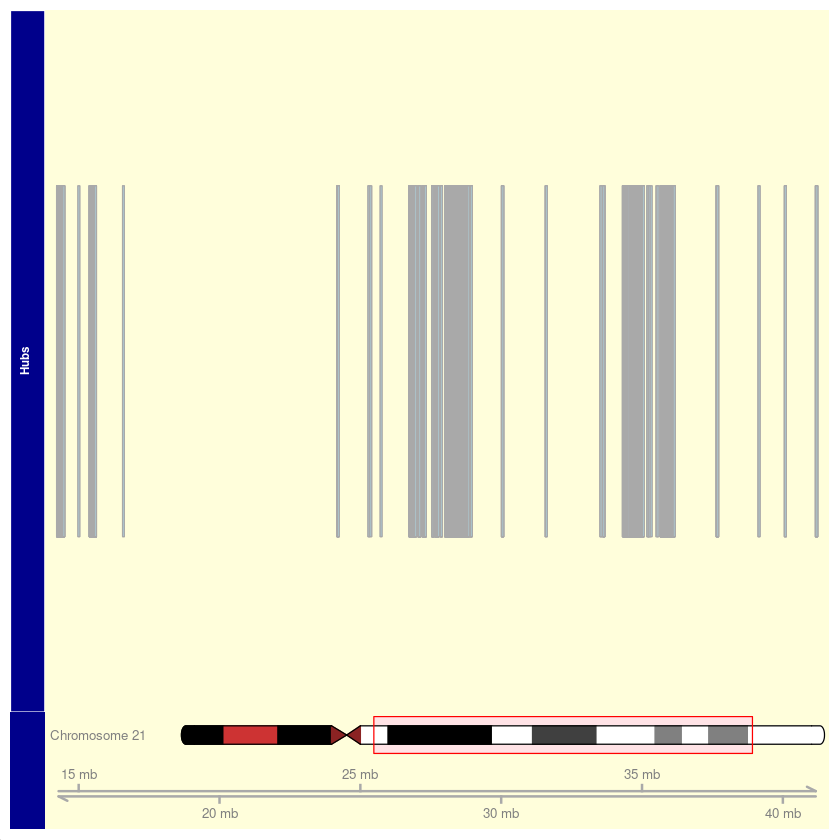

In [50]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = imr90gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

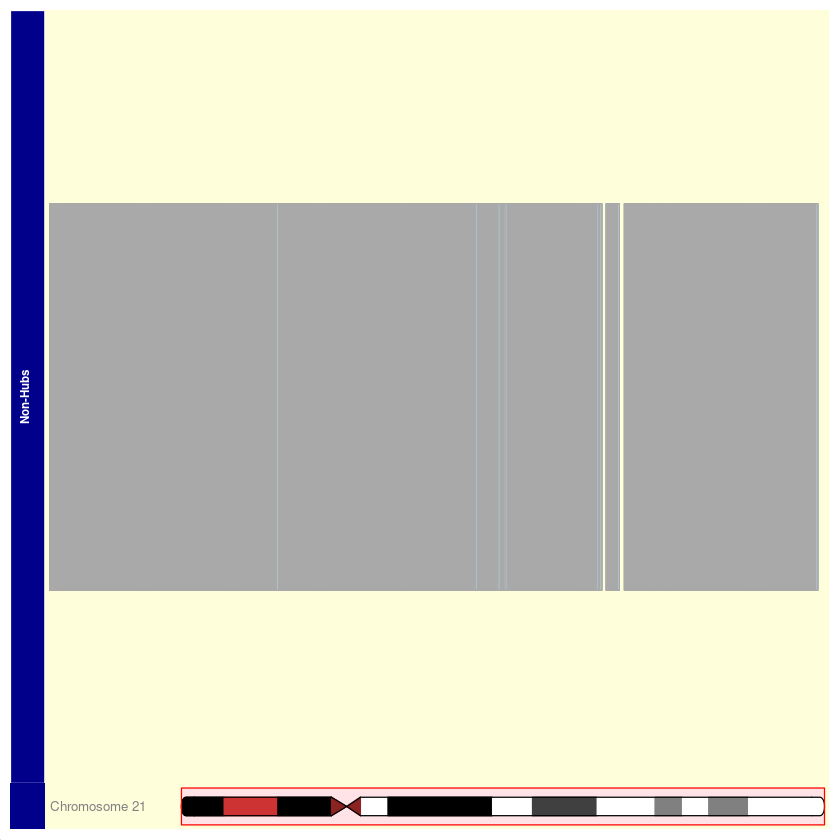

In [51]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = imr90gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [52]:
imr90gregPredicted <- cbind(imr90gregStandardRegionsClass, imr90gregModelPredictionsProbs)
names(imr90gregPredicted)[names(imr90gregPredicted) == "imr90gregModelPredictionsProbs"] <- "Prediction"
imr90gregPredicted$Prediction <- ifelse(imr90gregPredicted$Prediction == 1, "Hub", "Non-Hub")  

Let us see if the classifier predictions match with the original results.

In [53]:
imr90gregChr21PredicitedHub <- imr90gregPredicted[imr90gregPredicted$chr=="chr21" & imr90gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

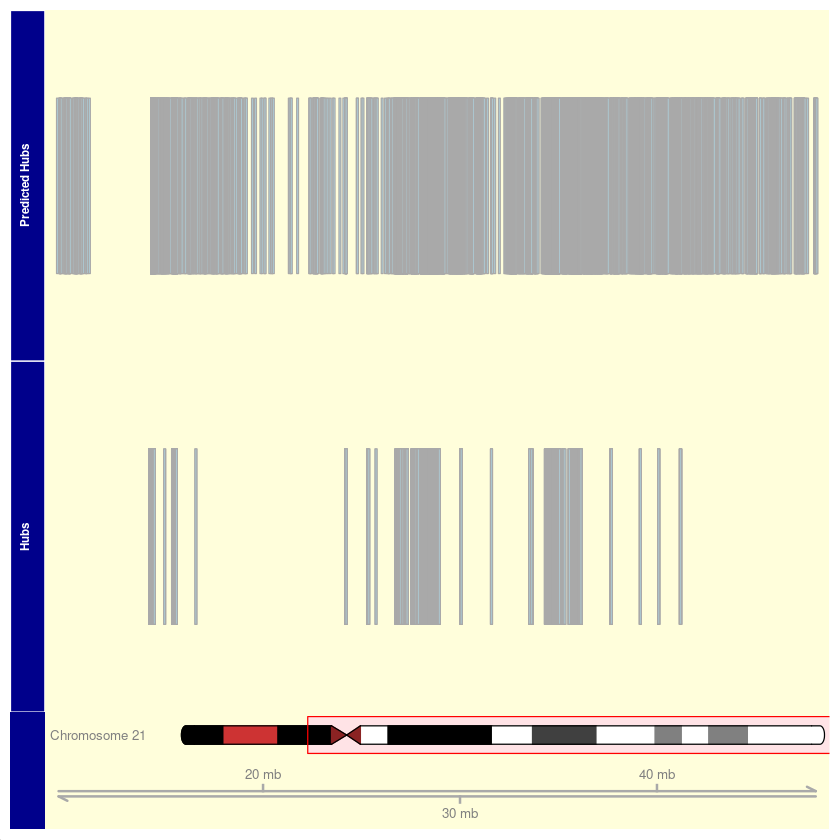

In [54]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = imr90gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = imr90gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [55]:
truePositives <- imr90gregPredicted[imr90gregPredicted$Class == imr90gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [56]:
## Saving relevant files

save(imr90rf1, file = "./optimalModels/imr90modelRF") # optimal model
write.table(truePositives, file = "./truePositives/imr90RF.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteData, file = "./buildData/optimalModelTrainIMR90RF.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestIMR90RF.txt", quote = FALSE) # data used to test model

In [57]:
table(smoteData$Class)


     0      1 
199879 199879 

## Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| imr90rf1 | 87.82932 % | 89.32611 % | 79.01205 % | Very Good

Also, note that data on which the model was trained has a distribution of 199879:199879 = 1 in class proportion. So, the probability of finding any class is 50% (ideally) because we have a homogeneous spread of class labels. Despite since the model has slightly higher sensitivity, i.e. higher knack for predicting positive classes, the performance could be considered exceptional, despite of not-so-bad accuracy. In addition, we observe that the model has a high specificity. This symbolises that the negative classes are also marked considerably well.   

##  <a id=link11>4. Session Information </a>

In [58]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         e1071_1.7-3         
[10] ggplot2_3.3.2        ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l